# Analysis of wage and hour case data from US state labor agencies

## Data import and preparation

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from src import shared_functions as sf

tqdm.pandas()
pd.set_option("display.float_format", lambda x: "%.3f" % x)


In [2]:
df = (
    pd.read_csv(
        "input/state_complaints.csv.gz",
        low_memory=False,
        parse_dates=["date_opened", "date_closed", "date_paid"],
    )
    # keep only 1 row per case. some rows contain multiple violation
    # categories, but this notebook will not address those.
    .drop_duplicates(subset="case_uuid", keep="first")
)


In [3]:
df.shape


(650452, 18)

### Data completeness


The data states provided in response to my public records requests was wildly inconsistent. I requested a long list of fields -- case statuses, start, end and paid dates, amounts claimed, assessed by the agency and paid -- but not all states possessed that data. Many states exported data directly from their case management systems, so lots of those fields were missing. This section will examine the completeness of various data points and explain how I am handling missing data. 

NOTE: the `get_coverage_df` function outputs the completeness (% non-null) of key columns in the analysis. You can find it at `shared/src/shared_functions.py`.

The data overall is very incomplete and has a ton of missing values. This is largely because many of the cases sent from case management systems are not completed. 

In [4]:
sf.get_coverage_df(df, by_state=False)


case_status       0.426
amount_claimed    0.521
amount_assessed   0.402
amount_paid       0.382
date_opened       0.985
date_closed       0.231
dtype: float64

This state breakdown heatmap shows which states have which data. 

<AxesSubplot: ylabel='state_name'>

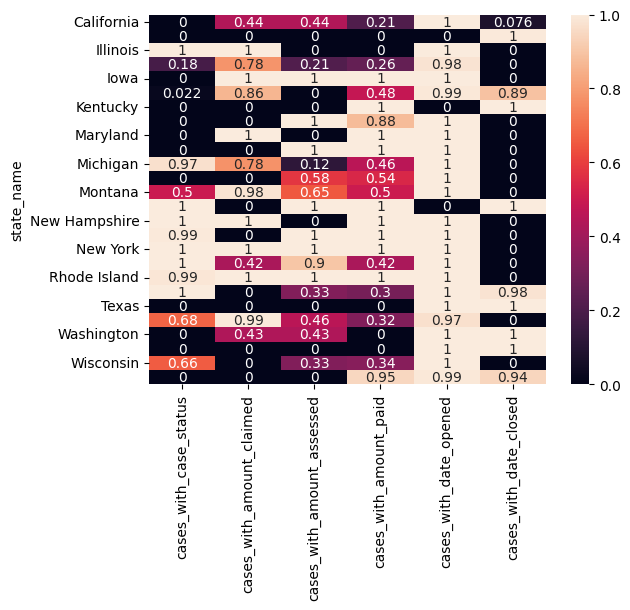

In [5]:
sns.heatmap(sf.get_coverage_df(df).iloc[:, 1:], annot=True)


The `determine_case_outcome` task of this repo assigns a `case_decided_in_favor_of_claimant` column to the dataframe, as well as the reason why that task determined the case outcome. 

In [6]:
df[
    ["case_decided_in_favor_of_claimant", "case_decided_in_favor_of_claimant_reason"]
].value_counts().to_frame("rows")


rows
case_decided_in_favor_of_claimant case_decided_in_favor_of_claimant_reason                  
True                              has amount paid                                     237082
False                             has no amount values                                178282
True                              state only provided closed cases                     60683
False                             has no assessed amount, but state provided asse...   49081
True                              has assessed amount greater than 0                   44684
False                             has assessed amount less than or equal to 0          37868
                                  has open or incomplete case status                   28684
True                              has final case status                                 2947

When you select only cases marked completed, you get much better completeness.

In [7]:
sf.get_coverage_df(df.query("case_decided_in_favor_of_claimant == True"), by_state=False)


case_status       0.442
amount_claimed    0.636
amount_assessed   0.613
amount_paid       0.687
date_opened       0.975
date_closed       0.286
dtype: float64

<AxesSubplot: ylabel='state_name'>

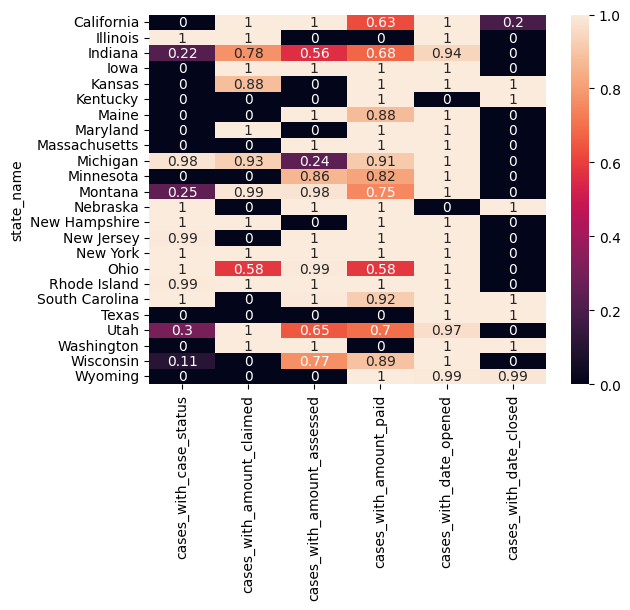

In [8]:
sns.heatmap(
    sf.get_coverage_df(df.query("case_decided_in_favor_of_claimant == True")).iloc[:, 1:],
    annot=True,
)


Texas provided data separately. Unless the AG sides with me (I'm still awaiting a decision), they determined that the amounts were private personal financial information. They did, however, provide me a file containing only the amounts that cannot be linked to the case data. For analyses of amounts, I'll add that data separately and remove the other Texas case information. 

See [shared_functions.py](../../shared/src/shared_functions.py#append_texas_amounts)


With the Texas amounts added, and incomplete cases removed, the amount fields still contain missing data but almost all cases contain at least one non-null amount. 

In [9]:
no_amounts = (
    df.pipe(sf.append_texas_amounts, filename="input/texas_amounts.csv.gz")
    .query("case_decided_in_favor_of_claimant == True")
    .query("amount_claimed.isnull() &  amount_assessed.isnull() & amount_paid.isnull()")
)
atleast_one_amount = df.query("case_decided_in_favor_of_claimant == True").query(
    "amount_claimed.notnull() | amount_assessed.notnull() | amount_paid.notnull()"
)
print(
    f"{no_amounts.shape[0]} rows "
    f"(%{no_amounts.shape[0]/len(df.query('case_decided_in_favor_of_claimant == True')) * 100:,}) "
    "have no amounts"
)


396 rows (%0.11465100927630895) have no amounts


There are also indeterminate cases, in which I couldn't determine whether the case was completed 

In [10]:
df[df.case_status == "amount exceeds statutory limit"]


,case_uuid,violation_uuid,state_name,employer_name,employer_dba_name,employer_city,violation_category,case_status,date_opened,date_paid,date_closed,amount_claimed,amount_assessed,amount_paid,case_decided_in_favor_of_claimant,case_decided_in_favor_of_claimant_reason,overall_case_amount,case_duration
626545,d6fe9235-f7c9-4fbb-9528-33c8c8a33793,b501eb08-01fd-465d-8654-4c327212abb9,Indiana,Mission Complete Transport LLC,NaN,NaN,NaN,amount exceeds statutory limit,2019-09-14,NaT,NaT,NaN,NaN,NaN,False,has open or incomplete case status,NaN,NaN
626713,6a4a2fa3-ac76-4c2c-a15d-495729a8d88d,497a40ca-7237-4b21-848b-9ddb3f65c0df,Indiana,Diverse Net,NaN,NaN,NaN,amount exceeds statutory limit,2019-11-04,NaT,NaT,NaN,NaN,NaN,False,has open or incomplete case status,NaN,NaN
626749,1e7b6072-d656-4a7b-9953-52b1e7499e1b,511f4bda-137e-41e3-850c-7629f3a644c4,Indiana,Code red safety,NaN,NaN,NaN,amount exceeds statutory limit,2019-12-31,NaT,NaT,NaN,NaN,NaN,False,has open or incomplete case status,NaN,NaN
626774,42ab3179-cf6b-4e40-8b6d-42bc665c9f02,f3c7eb96-8649-4873-ab01-7ba9b77727b0,Indiana,Morningview Assisted Living,NaN,NaN,NaN,amount exceeds statutory limit,2019-12-16,NaT,NaT,NaN,NaN,NaN,False,has open or incomplete case status,NaN,NaN
626785,ac4726c1-fa3f-4639-9a1d-ac0b12350c52,5778756e-3b11-4e2e-96e7-af832d22b721,Indiana,"Hidden Valley Inn, Inc",NaN,NaN,NaN,amount exceeds statutory limit,2019-09-23,NaT,NaT,NaN,NaN,NaN,False,has open or incomplete case status,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
647666,34e47f6f-0caf-4bb2-a91d-b7e2fd044a98,371e2ce6-571e-44d7-9748-140b4b261838,Indiana,Creative Technic,NaN,NaN,NaN,amount exceeds statutory limit,2019-07-15,NaT,NaT,6145.500,NaN,NaN,False,has open or incomplete case status,6145.500,NaN
647714,ca1e349f-efee-431a-a913-4687af3f523f,2fdc21a9-2266-4a1c-b7b3-2506fcb16335,Indiana,Aaa Mattress & Furniture,NaN,NaN,NaN,amount exceeds statutory limit,2019-06-18,NaT,NaT,10000.000,NaN,NaN,False,has open or incomplete case status,10000.000,NaN
647742,cc52bc3c-466b-4355-836f-8b364a354b73,8d6bb2f2-2193-4282-a5ae-f18879e5cb35,Indiana,Trugreen Lawncare,NaN,NaN,NaN,amount exceeds statutory limit,2019-06-24,NaT,NaT,6733.000,NaN,NaN,False,has open or incomplete case status,6733.000,NaN
647848,7548ead1-c13a-4936-8c9a-4595137add69,0380a7c0-cf58-4131-aad0-36785778f78a,Indiana,XY Tool & Die,NaN,NaN,NaN,amount exceeds statutory limit,2019-07-15,NaT,NaT,9771.130,NaN,NaN,False,has open or incomplete case status,9771.130,NaN


In [11]:
df.query("case_decided_in_favor_of_claimant.isnull()")


,case_uuid,violation_uuid,state_name,employer_name,employer_dba_name,employer_city,violation_category,case_status,date_opened,date_paid,date_closed,amount_claimed,amount_assessed,amount_paid,case_decided_in_favor_of_claimant,case_decided_in_favor_of_claimant_reason,overall_case_amount,case_duration
307280,6f557c25-8090-438c-b468-e34d3501a748,40323844-8df7-4b83-b1ce-3089c52f71ef,Illinois,The Lucky Hot dog,NaN,NaN,NaN,closed,2022-09-28,NaT,NaT,436.000,NaN,NaN,NaN,closed case with no assessed amount and no pai...,436.000,NaN
307281,864217e1-e07a-4f1f-a6ed-469318eb3e51,a29ab7cd-ced8-439b-81e0-cd2a7778c0d4,Illinois,The Lucky Hot dog,NaN,NaN,NaN,closed,2022-09-28,NaT,NaT,446.800,NaN,NaN,NaN,closed case with no assessed amount and no pai...,446.800,NaN
307282,d4f635c1-c357-4331-9e56-cde19961c9f7,525b4a61-2dd7-408b-a72a-03291c03befc,Illinois,The Lucky Hot dog,NaN,NaN,NaN,closed,2022-09-27,NaT,NaT,479.300,NaN,NaN,NaN,closed case with no assessed amount and no pai...,479.300,NaN
307283,0fde0606-1108-4f4e-a237-ce2501da787a,78c31a0d-0e66-4014-b5d8-f1c35138640a,Illinois,The Lucky Hot dog,NaN,NaN,NaN,closed,2022-09-27,NaT,NaT,420.880,NaN,NaN,NaN,closed case with no assessed amount and no pai...,420.880,NaN
307284,cc40d977-616b-4592-b745-f3eaf798ce36,320ba338-262a-404e-8f39-11ce9d4f5ad8,Illinois,The Lucky Hot dog,NaN,NaN,NaN,closed,2022-09-27,NaT,NaT,487.210,NaN,NaN,NaN,closed case with no assessed amount and no pai...,487.210,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331062,0c68b3dc-8160-4813-ae59-ad609f13e457,46e9a477-defd-4398-b2c5-11a3912cca9e,Illinois,BLUE CHIP 2000,NaN,NaN,NaN,closed,2017-01-05,NaT,NaT,126.000,NaN,NaN,NaN,closed case with no assessed amount and no pai...,126.000,NaN
331063,2ca36515-8ddb-4893-9ac3-ec14d416a1b8,888e73ff-e1be-4b0f-b1b4-b581c6fd9629,Illinois,TRIPLE S SERVICES,NaN,NaN,NaN,closed,2017-01-05,NaT,NaT,960.000,NaN,NaN,NaN,closed case with no assessed amount and no pai...,960.000,NaN
331069,4929b2df-c2ef-47e5-a56b-a526657e7f98,931df107-7aa5-4520-9424-20abb2a549e4,Illinois,TOTAL EXPRESS,NaN,NaN,NaN,closed,2017-01-03,NaT,NaT,3500.000,NaN,NaN,NaN,closed case with no assessed amount and no pai...,3500.000,NaN
331070,437b5ba7-fac0-47bf-a546-06fd5a912491,a0e610fe-4c18-4e19-89f5-53a4920a8324,Illinois,EATALY,NaN,NaN,NaN,closed,2017-01-03,NaT,NaT,41.600,NaN,NaN,NaN,closed case with no assessed amount and no pai...,41.600,NaN


They contain very incomplete data, but all for one single reason: they are closed cases with no assessed amount and no paid amount in a state that didn't provide either. 

If the state provided either an assessed or paid amount, I can use those to determine the case outcome. But if the state provided only claim amounts or no amounts at all AND no clear case disposition other than "closed," I can't be confident that those cases are all decided in favor of the claimants. 

In [12]:
print(
    df.query(
        "case_decided_in_favor_of_claimant.isnull()"
    ).case_decided_in_favor_of_claimant_reason.value_counts()
)
sf.get_coverage_df(df.query("case_decided_in_favor_of_claimant.isnull()"), by_state=False)


closed case with no assessed amount and no paid amount in a state that provided neither    11141
Name: case_decided_in_favor_of_claimant_reason, dtype: int64


case_status       0.999
amount_claimed    1.000
amount_assessed   0.000
amount_paid       0.000
date_opened       1.000
date_closed       0.000
dtype: float64

Those cases come only from three states -- Illinois, West Virginia and Colorado. All of those provided insufficient data to analyze 


In [13]:
df.query("case_decided_in_favor_of_claimant.isnull()").state_name.value_counts()


Illinois    11141
Name: state_name, dtype: int64

## Analysis

Below you will find basic descriptive statistics and state breakdowns. I will expand on this in the coming days, including by making comparisons to average household income and consumer expenses. 1 

I will focus on the following data points: 
1. overall amount assessed and the impacts that can have
2. amount claimed or assessed by the state vs. the amount paid by the company
3. the amount of time these cases take to resolve


All cases used in this analysis are decided in favor of the claimant unless otherwise specified. 

### Overall case amounts

In [14]:
amount_df = (
    df.query("case_decided_in_favor_of_claimant == True")
    # appending texas to the end of the state name because there are
    # amounts stored separately
    .pipe(sf.append_texas_amounts, filename="input/texas_amounts.csv.gz")
)
amount_df.overall_case_amount.describe()


count    346165.000
mean       4581.853
std       30530.137
min           0.000
25%         200.000
50%         715.000
75%        2400.000
max     5912348.830
Name: overall_case_amount, dtype: float64

In [15]:
print(f"Total amount across all states: {amount_df.overall_case_amount.sum():,.0f}")


Total amount across all states: 1,586,077,186


In [16]:
(
    amount_df.groupby(
        pd.cut(
            amount_df.overall_case_amount,
            [
                0,
                100,
                500,
                1000,
                2500,
                5000,
                10000,
                50000,
                100000,
                500000,
                1000000,
                99999999999999,
            ],
        )
    )
    .size()
    .to_frame("total_cases")
    .rename(
        index={
            pd.Interval(0, 100, closed="right"): "$0 - $100",
            pd.Interval(100, 500, closed="right"): "$100 - $500",
            pd.Interval(500, 1000, closed="right"): "$500 - $1,000",
            pd.Interval(1000, 2500, closed="right"): "$1,000 - $2,500",
            pd.Interval(2500, 5000, closed="right"): "$2,500 - $5,000",
            pd.Interval(5000, 10000, closed="right"): "$5,000 - $10,000",
            pd.Interval(10000, 50000, closed="right"): "$10,000 - $50,000",
            pd.Interval(50000, 100000, closed="right"): "$50,000 - $100,000",
            pd.Interval(100000, 500000, closed="right"): "$100,000 - $500,000",
            pd.Interval(500000, 1000000, closed="right"): "$500,000 - $1,000,000",
            pd.Interval(1000000, 99999999999999, closed="right"): "$1,000,000+",
        }
    )
    .assign(pct_of_total_cases=lambda df: df.total_cases / df.total_cases.sum())
)


,total_cases,pct_of_total_cases
overall_case_amount,,
$0 - $100,24610,0.080
$100 - $500,83237,0.270
"$500 - $1,000",55690,0.181
"$1,000 - $2,500",61080,0.198
"$2,500 - $5,000",33460,0.109
"$5,000 - $10,000",23038,0.075
"$10,000 - $50,000",22247,0.072
"$50,000 - $100,000",2689,0.009
"$100,000 - $500,000",1961,0.006


In [17]:
amount_df.groupby("state_name").overall_case_amount.sum().to_frame("overall_case_amount").join(
    amount_df.groupby("state_name").overall_case_amount.describe()
)


,overall_case_amount,count,mean,std,min,25%,50%,75%,max
state_name,,,,,,,,,
California,558617653.636,63442.000,8805.171,44730.691,0.000,295.025,2070.010,6955.500,5912348.830
Illinois,4213957.400,769.000,5479.789,11667.095,0.000,882.260,2300.000,5804.840,156500.000
Indiana,39404254.013,7832.000,5031.187,51612.102,0.000,245.642,590.550,1524.862,2297378.000
Iowa,853899.000,7370.000,115.861,625.433,0.000,0.000,0.000,0.000,7625.000
Kansas,10508991.876,4931.000,2131.209,29528.906,0.440,250.000,560.000,1280.500,2019015.000
Kentucky,23838093.630,7020.000,3395.740,16168.527,25.380,207.765,398.645,1164.223,125810.820
Maine,1977300.070,792.000,2496.591,8276.580,2.750,222.040,585.750,1551.312,153993.440
Maryland,20140568.600,8290.000,2429.502,6628.096,0.000,384.000,934.470,2200.000,287701.580
Massachusetts,48474294.560,2419.000,20038.981,75475.087,0.000,857.320,2560.000,9826.160,1325287.250


### Amounts recovered

In [18]:
paid_df = (
    amount_df.assign(
        amount_claimed_or_assessed=lambda df: df.apply(
            lambda row: row.amount_assessed
            if pd.notna(row.amount_assessed)
            else row.amount_claimed,
            axis=1,
        )
    )
    # only use rows from states that provided paid amounts and assessed or claimed amounts
    .pipe(
        lambda df: df[
            df.state_name.isin(
                sf.get_coverage_df(amount_df)
                .query(
                    "cases_with_amount_paid > 0 & (cases_with_amount_claimed > 0 | cases_with_amount_assessed > 0)"
                )
                .index
            )
        ]
    )
)

(
    paid_df.assign(
        has_amount_paid=lambda df: df.amount_paid.notnull() & df.amount_paid > 0
    )
    .has_amount_paid.value_counts()
    .to_frame("total_cases")
    .assign(pct_of_total_cases=lambda df: df.total_cases / df.total_cases.sum())
)


,total_cases,pct_of_total_cases
True,187641,0.566
False,143854,0.434


In [19]:
print(f"Total amount paid: {paid_df.amount_paid.sum():,.0f}")


Total amount paid: 631,838,076


In [20]:
(
    paid_df.groupby("state_name")
    .size()
    .to_frame("total_cases")
    .join(
        paid_df.query("amount_paid > 0")
        .groupby("state_name")
        .size()
        .to_frame("cases_with_paid_amounts")
    )
    .join(
        paid_df.groupby("state_name").amount_paid.sum().to_frame("total_amount_paid")

    )
    .assign(
        pct_of_total_cases=lambda df: df.cases_with_paid_amounts / df.total_cases,
    )
)


,total_cases,cases_with_paid_amounts,total_amount_paid,pct_of_total_cases
state_name,,,,
California,63442,26509,126853456.268,0.418
Indiana,8175,5541,3645489.950,0.678
Iowa,7370,3199,2617419.000,0.434
Kansas,4931,4931,10508991.876,1.000
Maine,792,690,1451891.010,0.871
Maryland,8290,5102,8346019.710,0.615
Massachusetts,2419,2408,48474294.560,0.995
Michigan,41787,37796,36834248.610,0.904
Minnesota,745,606,5319233.840,0.813


### Case duration

In [21]:
duration_df = (
    df.query("case_decided_in_favor_of_claimant == True")
    .copy()
    .assign(case_duration=lambda x: x.date_closed - x.date_opened)
    .assign(duration_days=lambda x: x.case_duration.dt.days)
)

duration_df.case_duration.describe()


count                          91217
mean     310 days 14:02:53.448449204
std      412 days 07:59:42.409025324
min                  0 days 00:00:00
25%                105 days 00:00:00
50%                195 days 00:00:00
75%                337 days 00:00:00
max               4585 days 00:00:00
Name: case_duration, dtype: object

In [22]:
(
    duration_df.groupby(
        pd.cut(duration_df.duration_days, [0, 30, 60, 90, 180, 360, 720, 999999])
    )
    .size()
    .to_frame("total_cases")
    .rename(
        index={
            pd.Interval(0, 30, closed="right"): "0-30 days",
            pd.Interval(30, 60, closed="right"): "30-60 days",
            pd.Interval(60, 90, closed="right"): "60-90 days",
            pd.Interval(90, 180, closed="right"): "90-180 days",
            pd.Interval(180, 360, closed="right"): "180-360 days",
            pd.Interval(360, 720, closed="right"): "360-720 days",
            pd.Interval(720, 999999, closed="right"): "720+ days",
        }
    )
    .assign(pct_of_total_cases=lambda df: df.total_cases / df.total_cases.sum())
)


,total_cases,pct_of_total_cases
duration_days,,
0-30 days,4594,0.050
30-60 days,5102,0.056
60-90 days,8393,0.092
90-180 days,24256,0.266
180-360 days,28515,0.313
360-720 days,12934,0.142
720+ days,7323,0.080


In [23]:
duration_df.groupby("state_name").duration_days.describe().dropna()


,count,mean,std,min,25%,50%,75%,max
state_name,,,,,,,,
California,12366.000,523.836,306.061,26.000,300.000,439.000,676.750,1951.000
Kansas,4917.000,158.355,306.790,0.000,47.000,99.000,168.000,3869.000
South Carolina,4807.000,65.342,48.877,0.000,35.000,57.000,84.000,826.000
Texas,60683.000,332.816,450.520,29.000,133.000,208.000,323.000,4585.000
Washington,6364.000,55.863,55.484,0.000,22.000,43.000,69.000,1197.000
Wyoming,2080.000,99.992,137.802,0.000,24.000,48.000,124.000,1114.000


### Comparison to state felony theft thresholds


In [24]:
felony_thresholds = (
    pd.read_csv("input/felony_thresholds.csv")[["state_name", "felony_theft_threshold"]]
    .set_index("state_name")
    .to_dict(orient="index")
)

felony_threshold_df = df.assign(
    felony_theft_threshold=lambda d: d.state_name.map(felony_thresholds).apply(
        lambda x: x["felony_theft_threshold"]
    )
).assign(felony_theft=lambda d: d.overall_case_amount >= d.felony_theft_threshold)

(
    felony_threshold_df.groupby("felony_theft")
    .size()
    .to_frame("total_cases")
    .assign(pct_of_total_cases=lambda d: d.total_cases / d.total_cases.sum())
)


,total_cases,pct_of_total_cases
felony_theft,,
False,483145,0.743
True,167307,0.257


In [25]:
(
    pd.crosstab(
        index=felony_threshold_df.state_name,
        columns=felony_threshold_df.felony_theft,
        values=felony_threshold_df.case_uuid,
        aggfunc="nunique",
    )
    .pipe(lambda d: pd.concat([d, d.sum().to_frame("total").T]))
    .assign(total=lambda d: d[True] + d[False])
    .assign(
        pct=lambda d: d[True] / d.total,
    )
)


felony_theft,False,True,total,pct
California,150618.000,39609.000,190227.000,0.208
Colorado,454.000,NaN,NaN,NaN
Illinois,7470.000,16339.000,23809.000,0.686
Indiana,12821.000,8690.000,21511.000,0.404
Iowa,7090.000,280.000,7370.000,0.038
Kansas,7171.000,3080.000,10251.000,0.300
Kentucky,3978.000,3159.000,7137.000,0.443
Maine,520.000,272.000,792.000,0.343
Maryland,5364.000,2926.000,8290.000,0.353
Massachusetts,802.000,1618.000,2420.000,0.669
